<img src="../logo_UTN.svg" align="right" width="150" /> 

# Teoría De Circuitos 2

# Trabajo Semanal Nº1
#### Federico Borello

### Consigna

Dado el circuito:

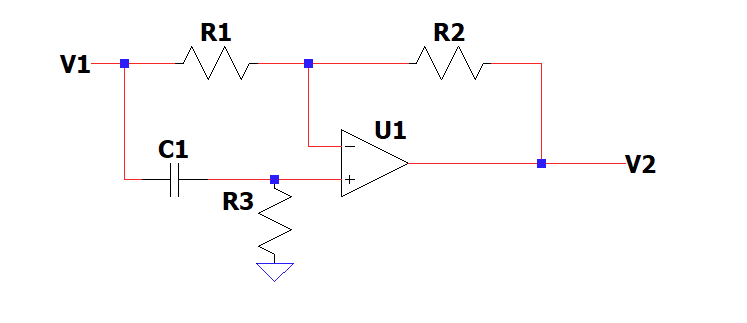

1. Obtener la función transferencia $\cfrac{V_2}{V_1}$ ( módulo , fase y diagrama de polos y ceros).
2. Proponga una norma de impedancia y frecuencia de forma tal de llegar a una transferencia normalizada.
3. Simule la función transferencia normalizada en Python. ([Ver ejemplos](https://pytc2.readthedocs.io/en/latest/notebooks/ejnb_filtro_pasivo_sos.html))
4. Simule la red normalizada en LTspice, y obtenga su respuesta en frecuencia. ([otro ejemplo](https://pytc2.readthedocs.io/en/latest/notebooks/ejnb_parametrizacion_pasabanda.html))
5. ¿Qué tipo de filtro es? ¿Qué utilidad podría tener este tipo de circuitos? 

Bonus:
- +1 💎 Obtener una RED normalizada que responda a la función hallada en el punto 2
- +1 🎓 Verifique los resultados de 1 y 2 mediante el módulo de simulación simbólica SymPy. ([ejemplo simpy](https://pytc2.readthedocs.io/en/latest/notebooks/ejnb_GIC_Antoniou.html))
- +1 🤯 Analice similitudes y diferencias con ambas redes del TP1, ej 7.

In [1]:
from IPython.display import HTML

file = "./TS1_handwritten.pdf"
html = f"""
<div style="text-align:center;">
    <iframe src="{file}" width="900" height="600"></iframe>
</div>
"""
HTML(html)

In [2]:
# SetUp - Import /utils module
import sys
import os

sys.path.append(os.path.abspath(".."))
import utils

# Import common packages
from IPython.display import display, Markdown
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Defino las Variables del circuito
V1, Vn, V2, R1, R2, R3, C = sp.symbols("V1 Vn V2 R1 R2 R3 C", real=True)
s = sp.symbols("s")  # s es una variable compleja

# Defino las ecuaciones de los nodos
eq1 = sp.Eq((V1 - Vn) / R1, (Vn - V2) / R2)
eq2 = sp.Eq((V1 - Vn) * (s * C), Vn / R3)

# Despejo Vn de una ecuacion
Vn_sol = sp.solve(eq2, Vn)
# Uso Vn en la otra ecuacion
eq1_sol = eq1.subs(Vn, Vn_sol[0])

# Obtengo V2
V2_sol = sp.solve(eq1_sol, V2)[0]

H = ratio_V2_V1 = sp.simplify(V2_sol / V1)

H

(C*R1*R3*s - R2)/(R1*(C*R3*s + 1))

# Caso de Estudio

Si $R_1 == R_2$ se tiene un AllPass filter.

In [4]:
# Normalizo en frecuencia
s_prime = sp.symbols("s^{\prime}")  # s es una variable compleja
omega0 = 1 / (C * R3)

# Sustituyo R1 por R2 -> R1 = R2
H = H.subs(R1, R2)
# Sustituyo s por s'
H_normalized = H.subs(s, s_prime * omega0)
H_normalized
sp.simplify(H_normalized)

(s^{\prime} - 1)/(s^{\prime} + 1)

In [5]:
# Obtengo el modulo y la fase de forma analítica

omega = sp.symbols("omega", real=True)
s_to_jw = H.subs(s, sp.I * omega)

# Separo en numerador y denominador
numerator = sp.fraction(s_to_jw)[0]
denominator = sp.fraction(s_to_jw)[1]

# Componentes de numerador y denominador
num_real = sp.re(numerator)
num_imag = sp.im(numerator)
denom_real = sp.re(denominator)
denom_imag = sp.im(denominator)

magnitude_num = sp.sqrt(num_real**2 + num_imag**2)
magnitude_denom = sp.sqrt(denom_real**2 + denom_imag**2)
magnitude_expr = sp.simplify(magnitude_num / magnitude_denom)

# Calculo de la fase
num_angle = sp.atan(num_imag / num_real)
denom_angle = sp.atan(denom_imag / denom_real)
total_phase = sp.simplify(num_angle - denom_angle)

# Pretty Print
magnitude_latex = sp.latex(magnitude_expr)
phase_latex = sp.latex(total_phase)

markdown_text = f"""
### Magnitud y Fase

- **Magnitud**: $${magnitude_latex}$$
- **Fase**: $${phase_latex}$$
    - Nota: Hay que tener cuidado con esta representacion, no tiene en cuenta que en $\omega = 0$ empieza en $\pi$, es mejor usar `atan2` en vez de `atan`.   
"""

display(Markdown(markdown_text))


### Magnitud y Fase

- **Magnitud**: $$1$$
- **Fase**: $$- 2 \operatorname{atan}{\left(C R_{3} \omega \right)}$$
    - Nota: Hay que tener cuidado con esta representacion, no tiene en cuenta que en $\omega = 0$ empieza en $\pi$, es mejor usar `atan2` en vez de `atan`.   


In [6]:
def plot_tf(tf, values, x):
    tf_numeric = tf.subs(values)
    # s to jω
    omega = sp.symbols("omega", real=True)
    s_to_jw = tf_numeric.subs(s, sp.I * omega)

    H = sp.lambdify(omega, s_to_jw, "numpy")

    # Genero frecuencias
    frequencies = np.logspace(0, x, 1000)  # 10^0 to 10^x Hz
    frequencies_rad = frequencies * 2 * np.pi

    # Evaluate magnitude and phase of the transfer function
    magnitude = np.abs(H(frequencies_rad))
    magnitude = np.round(magnitude, decimals=10)
    phase = np.angle(H(frequencies_rad))
    indices_pi = np.where(np.isclose(phase, np.pi / 2, atol=1e-3))[0]
    frequencies_pi = frequencies[indices_pi]
    print(f"Frecuencias donde la fase es aproximadamente π/2: {frequencies_pi}")

    # magnitude to dB
    magnitude_db = 20 * np.log10(magnitude)

    # phase to degrees
    phase_degrees = np.degrees(phase)

    # Ploteo
    _, ax1 = plt.subplots(figsize=(12, 6))

    ax1.semilogx(frequencies, magnitude_db, color="blue")
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Magnitude (dB)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(which="both", linestyle="--", linewidth=0.7)

    ax2 = ax1.twinx()
    ax2.semilogx(frequencies, phase_degrees, color="red")
    ax2.set_ylabel("Phase (degrees)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    plt.title("Bode Plot")
    plt.tight_layout()
    plt.show()

### Simulacion con una $\omega_0 = 1$ (Normalizada)

Se multiplica por $2 \pi$ para tener el gráfico centrado en $1[Hz]$.

Es muy dificil de visualizar el comportamiento de la fase con la transferencia normalizada.

Frecuencias donde la fase es aproximadamente π/2: [1.]


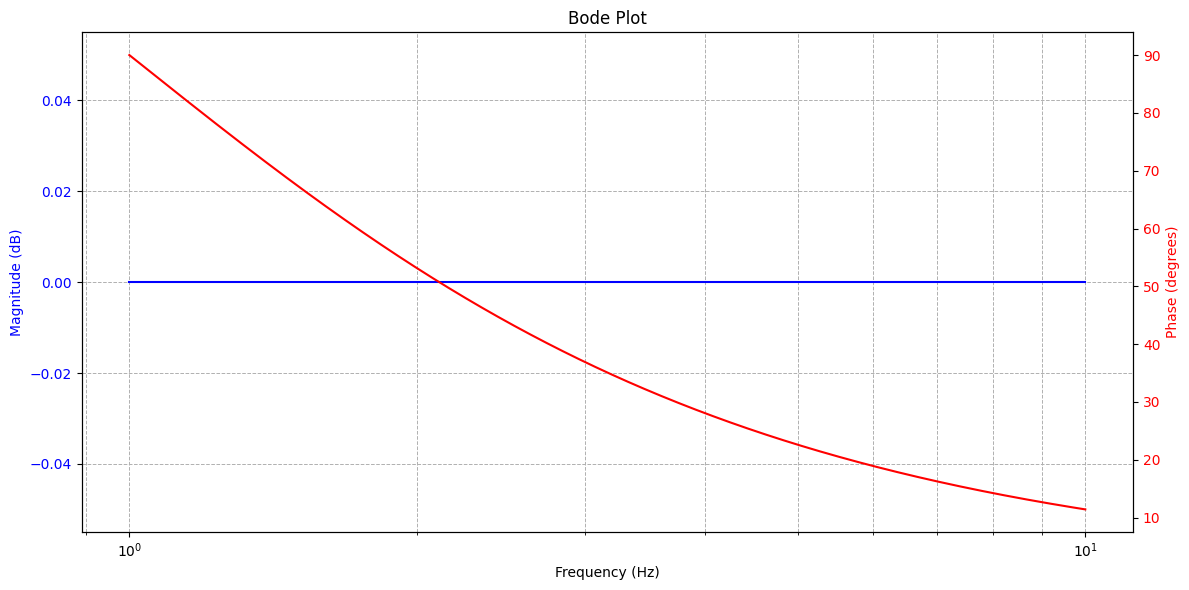

In [7]:
Rn = 1
R12 = 1
w0 = 2 * np.pi * 1
Q = 1
values = {R2: R12 / Rn, R3: Rn, C: Q * (Rn / w0)}

plot_tf(H, values, 1)

### Simulacion con una $\omega_0 \neq 1$

Se escala con una frecuencia de $f_0 = 1[kHz]$ para poder comprender mejor el funcionamiento del circuito.

Frecuencias donde la fase es aproximadamente π/2: [1000.]


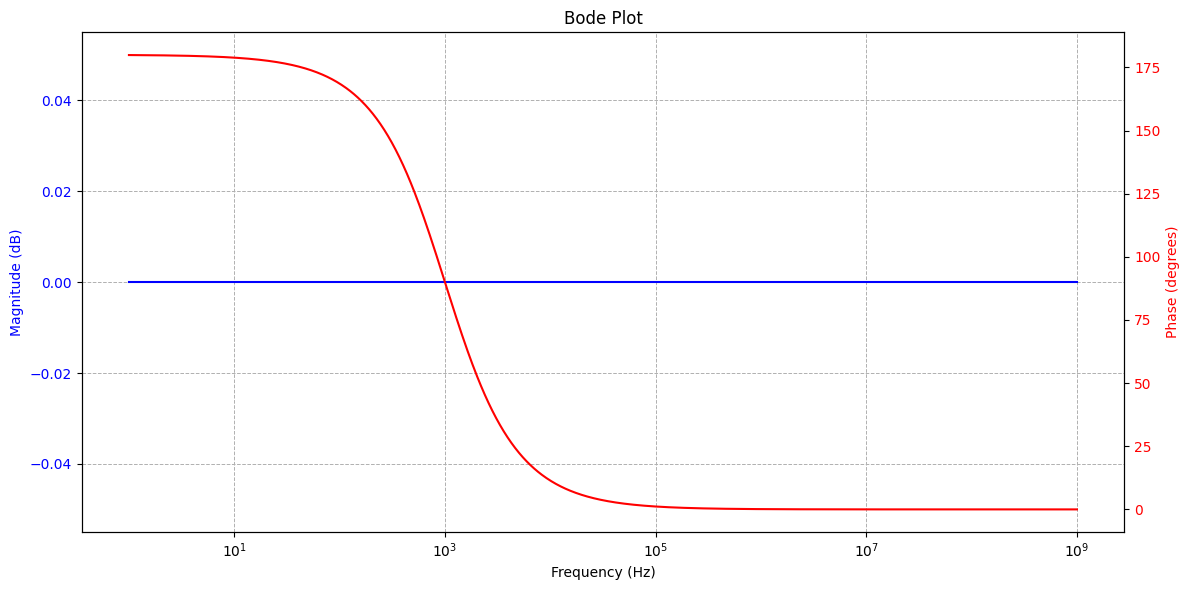

In [8]:
f = 1e3
Rn = 1
R12 = 1
w0 = 2 * np.pi * f
Q = 1
values = {R2: R12 / Rn, R3: Rn, C: Q * (Rn / w0)}

plot_tf(H, values, 9)

Para simular un amplificador operacional real, de manera rápida y práctica, se puede multiplicar la función de transferencia por la siguiente expresión:

$$\cfrac{1}{s+p_i}$$

Siendo $p_i$ la frecuencia a la cual se quiere el polo dominante de alta frecuencia. Un buen valor suele ser $30 [MHz]$, por lo tanto, la expresion quedaría de la siguiente manera:

$$\cfrac{1}{s+(2\pi \, 30 \times 10^{6})}$$

Además se debe multiplicar por $\omega_p$ para compensar la ganancia:

$$\cfrac{\omega_p}{s+\omega_p}$$

Frecuencias donde la fase es aproximadamente π/2: [1000.]


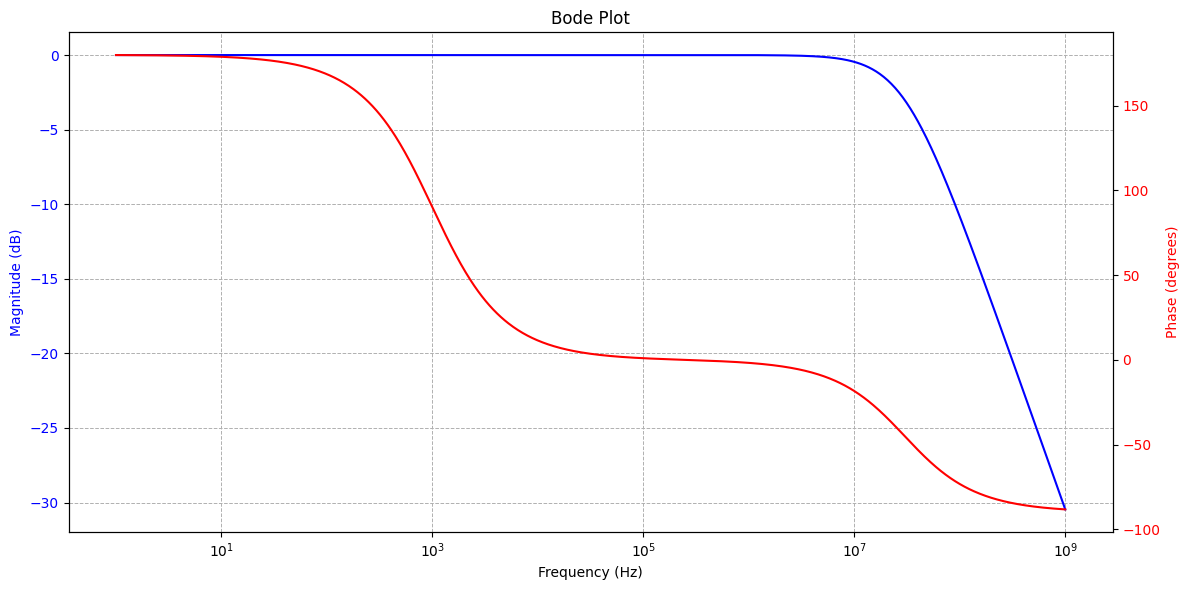

In [9]:
fp = 30e6
wp = 2 * np.pi * fp
# Se multiplica por wp para compensar la ganancia
H_real = H * (wp / (s + wp))
plot_tf(H_real, values, 9)

Se aprecia graficamente, y se calcula, que a la frecuencia de $1 [KHz]$ ($\omega_0 = 2\pi \, f$) la fase es de $\pi/2$.

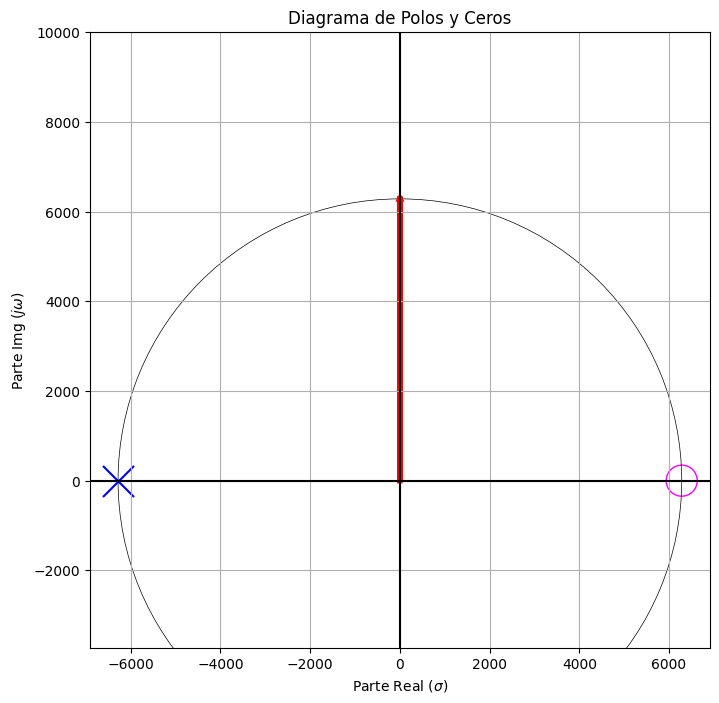

In [10]:
numerator = sp.fraction(H)[0]
denominator = sp.fraction(H)[1]

zeros = sp.solve(numerator, s)
poles = sp.solve(denominator, s)

f = 1e3
Rn = 1
w0 = 2 * np.pi * f
Q = 1
values = {R3: Rn, C: Q * (Rn / w0)}

zero = zeros[0].subs(values)
pole = poles[0].subs(values)

# Calculo el centro del círculo
center = (zero + pole) / 2
# Calculo el radio del círculo
radius = np.abs(center - zero)
radius = float(radius)

# Ploteo ceros y polos
plt.figure(figsize=(8, 8))
plt.scatter(
    np.real(zero),
    np.imag(zero),
    marker="o",
    edgecolors="magenta",
    facecolors="none",
    s=500,
)
plt.scatter(np.real(pole), np.imag(pole), marker="x", color="blue", s=500)

# Dibuja el círculo
circle = plt.Circle(
    (np.real(center), np.imag(center)),
    radius,
    edgecolor="black",
    facecolor="none",
    lw=0.5,
)
plt.gca().add_artist(circle)

# Flecha que indica el radio del círculo
plt.arrow(
    np.real(center),
    np.imag(center),
    0,
    radius,
    head_width=2,
    head_length=2,
    color="red",
    lw=4,
)

# Ploteo
plt.title("Diagrama de Polos y Ceros")
plt.xlabel(r"Parte Real $(\sigma)$")
plt.ylabel(r"Parte Img $(j\omega)$")
plt.grid(True)
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.axis("equal")
plt.show()

Se observa que el radio del circunferencia que pasa por el polo y el cero es igual a $\omega_0 = 2\pi \, 1[KHz]$

### Simualación con LT Spice

Para tener un gráfico más sencillo de analizar, desnormalizo a $f_0 = 1[kHz]$

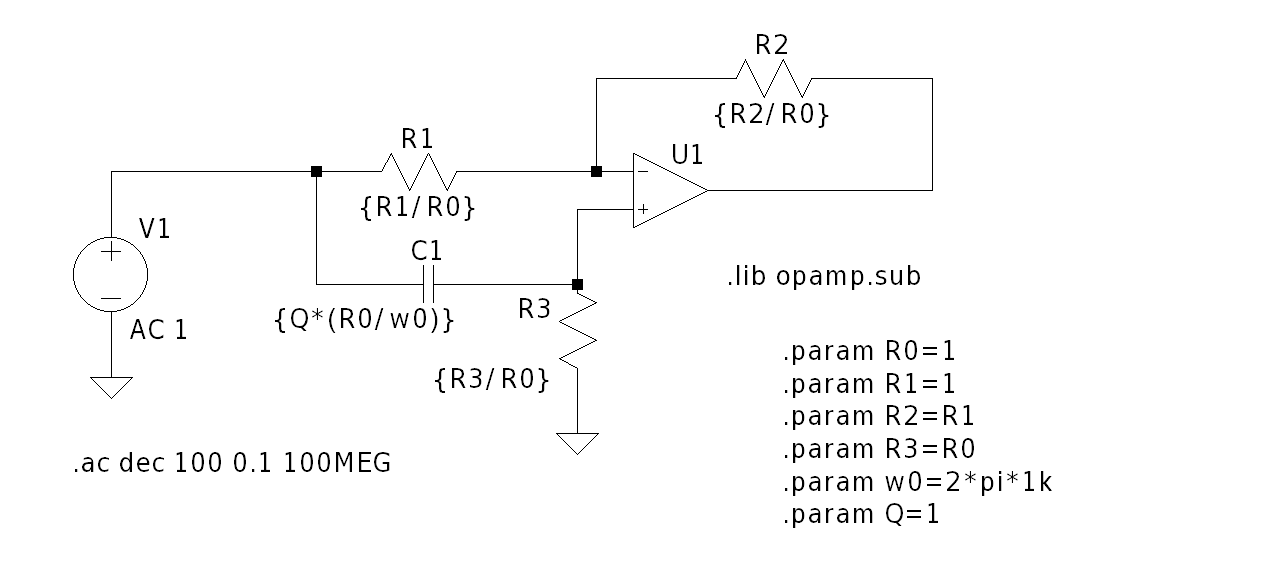
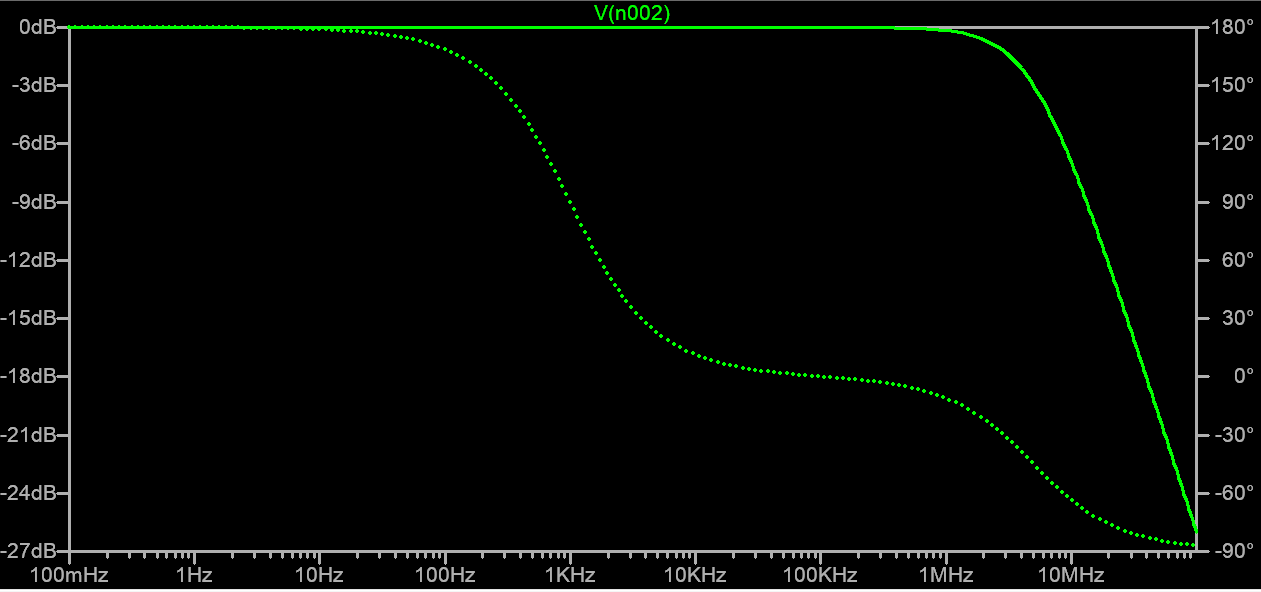

<a href="./TS1.asc" download="TS1.asc">Descargar TS1.asc</a>

## Comparación con un Circuito con Capacitores

- $\cfrac{R_A}{R_B} = \cfrac{G_B}{G_A} = 5$
- $R = 1 [k\Omega]$
- $C = 1 [\mu F]$

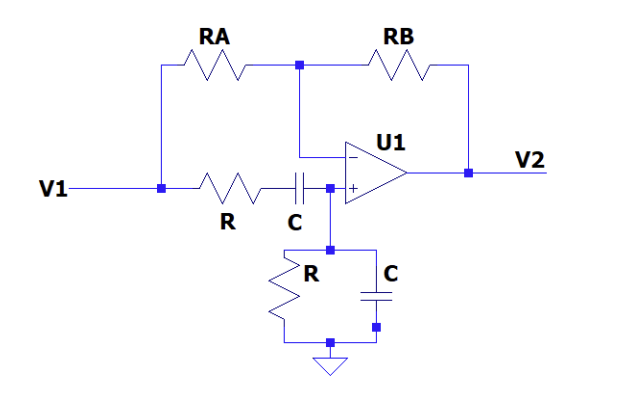

La transferencia genérica obtenida en el PDF adjunto es:

$$
T(s) = \cfrac{Y_2 \, Y_3 - Y_1 \, Y_4}{Y_2 \, Y_3 + Y_2 \, Y_4}
$$

In [11]:
Y1, Y2, Y3, Y4, G, GA, GB, C = sp.symbols(
    "Y_1 Y_2 Y_3 Y_4 G G_B G_A C", real=True, positive=True
)
s = sp.symbols("s")

# Defino la transferencia T(s)
num = (Y2 * Y3) - (Y1 * Y4)
den = (Y2 * Y3) + (Y2 * Y4)
T = num / den

T

(-Y_1*Y_4 + Y_2*Y_3)/(Y_2*Y_3 + Y_2*Y_4)

In [12]:
Y4_expr = G + s * C
Y3_expr = (1 / G + 1 / (s * C)) ** -1
Y1_expr = 1 / GA
# GB = 5*GA
Y2_expr = 1 / GB

values = {
    Y1: Y1_expr,
    Y2: Y2_expr,
    Y3: Y3_expr,
    Y4: Y4_expr,
}

T = T.subs(values)

T = sp.simplify(T)
T

(C*G*G_B*s - G_A*(C*s + G)**2)/(G_B*(C*G*s + (C*s + G)**2))


### Transferencia

$$H(s) = \frac{1.0 \cdot 10^{-9} s - 5.0 \cdot 10^{-6} \left(0.001 s + 1\right)^{2}}{1.0 \cdot 10^{-9} s + 1.0 \cdot 10^{-6} \left(0.001 s + 1\right)^{2}}$$


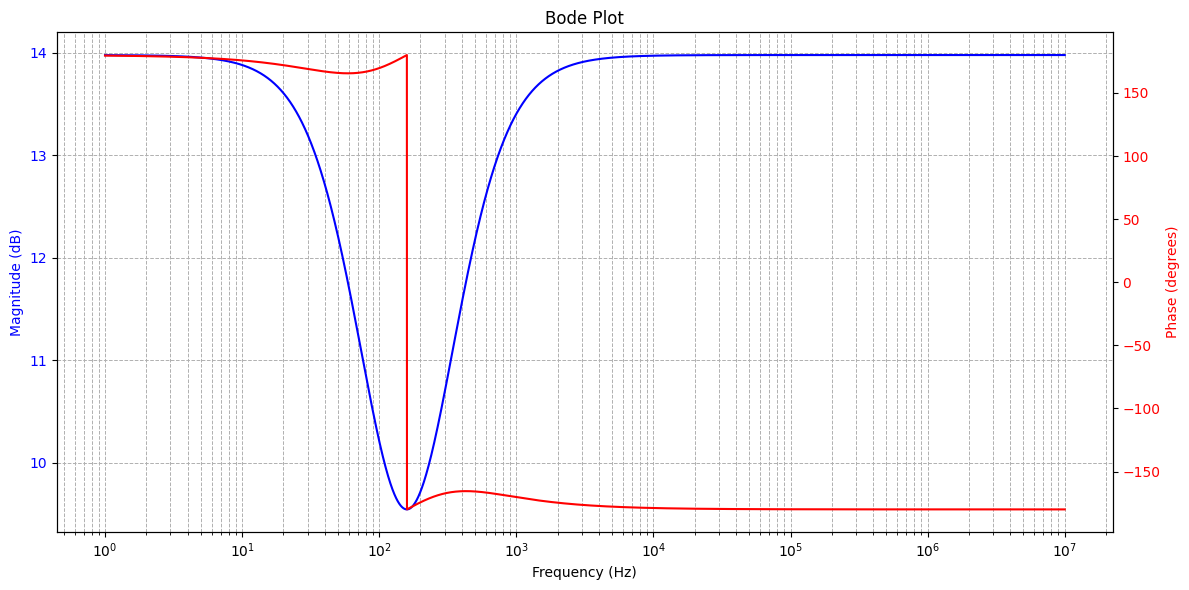

In [13]:
G_expr = 1 / 1e3
GA_expr = 1
C_expr = 1e-6

values = {
    Y1: Y1_expr,
    Y2: Y2_expr,
    Y3: Y3_expr,
    Y4: Y4_expr,
    G: G_expr,
    GA: GA_expr,
    GB: 5 * GA_expr,
    C: C_expr,
}

T1 = T.subs(values)

import utils.plot as uplt

(magnitude_db, frequencies, _) = uplt.plot_tf(T1, values)

### Diagrama de Polos y Ceros Cualitativos

Se procede a gráficar de manera cualitativa el diagrama de polos y ceros para entender el comportamiento del circuito.

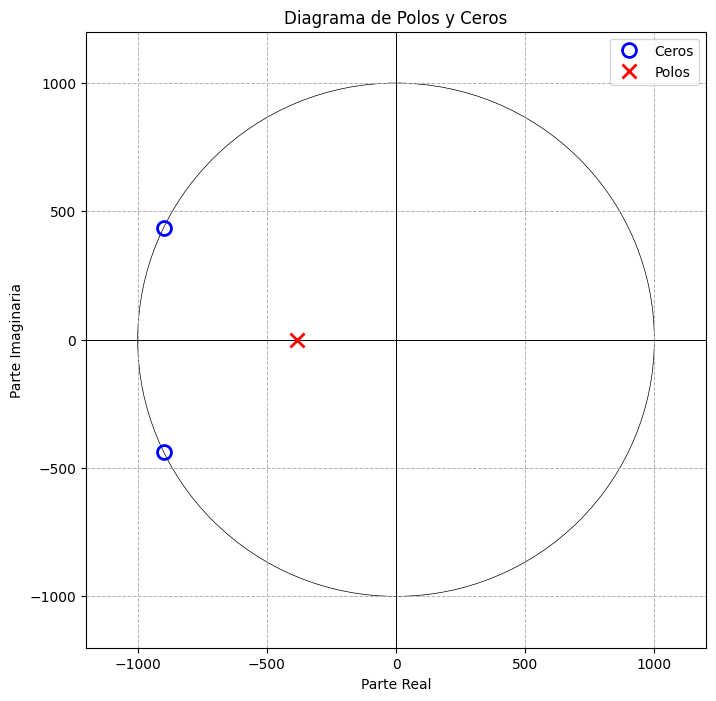

In [14]:
_ = uplt.plot_polos_ceros(T1, 1000, values)


### Transferencia

$$H(s) = \frac{1.0 \cdot 10^{-9} s - 1.0 \cdot 10^{-6} \left(0.001 s + 1\right)^{2}}{1.0 \cdot 10^{-9} s + 1.0 \cdot 10^{-6} \left(0.001 s + 1\right)^{2}}$$


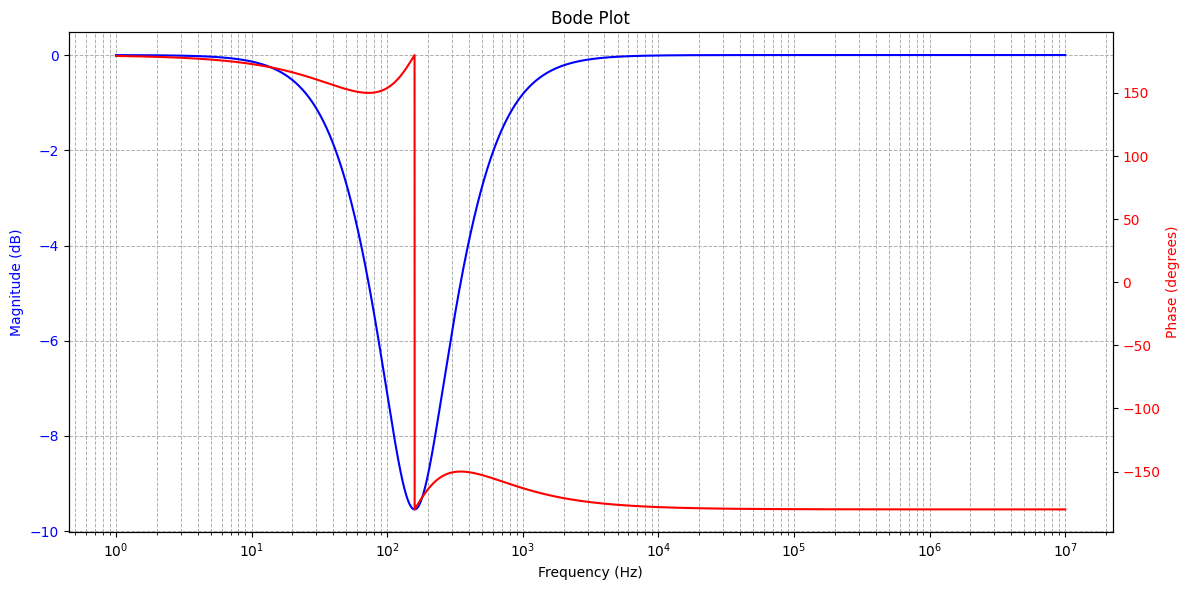

In [15]:
G_expr = 1 / 1e3
GA_expr = 1
C_expr = 1e-6

values = {
    Y1: Y1_expr,
    Y2: Y2_expr,
    Y3: Y3_expr,
    Y4: Y4_expr,
    G: G_expr,
    GA: GA_expr,
    GB: 1 * GA_expr,
    C: C_expr,
}

T2 = T.subs(values)

import utils.plot as uplt

(magnitude_db, frequencies, _) = uplt.plot_tf(T, values)

## Conclusiones

El filtro AllPass tiene ganancia 0, pero su respuesta en frecuencia varía dependiendo el $\omega_0$ elegido. Es útil para retrasar o adelantar frecuencias sin perjudicar la ganancia, los equipos de audio se pueden beneficiar de este comportamiento.

Por último se realizó una comparación con el circuito propuesto en el último apartado, el cual tiene un comportamiento de un filtro Notch, es decir, se comporta como un AllPass excepto que para una frecuencia (una banda muy selectiva) se atenúa la señal. En este caso, contamos con una ganancia provista por por $R_A$ y $R_B$, si $R_A == R_B$ se tiene exactamente el comportamiento detallado.

Es muy importante la comparación ya que el circuito solo agrega un capacitor en paralelo y un resistor en serie. El resistor en serie puede ser la **ESR** del capacitor ya existente en el AllPass y el capacitor en paralelo puede ser alguna capacidad parásita. Indicando que un filtro AllPass puede llegar a comportarse como un Notch en alguna condición de la realidad.